## TALLER HORA DEL CÓDIGO
### Universidad de Valladolid

##### César Hernández Rodríguez                                                                                                                               

Predicción de datos bursátiles con una RNN.

0. Estudio corto sobre Redes Neuronales y Series temporales bursátiles.
1. Descarga de datos mediante API Quandl. (https://www.quandl.com/)
2. Analizar datos y conjuntos.
3. Visualizar y entender datos elegidos.
4. Transformación de datos para entrenamiento de RNN.
5. Construcción y entrenamiendo de RNN.
6. Predicción de datos de validación.
7. Evaluación de diferentes modelos.

DATO: Mi código no es el mejor del mundo y seguro que hay formas mas eficientes.

### Estudio sobre Series Temporales Bursátiles.

* Análisis Fundamental y Análisis Técnico.
* Tipos de Tendencias, Resistencia, Soporte, Inversión a la alza y a la baja.
* Importancia de muchos atributos a la hora de variar el precio.

### Estudio de Redes Neuronales.

* ¿Qué es una red neuronal? Caja negra
* ¿Cómo funciona de manera simplificada? Fordward y Descenso de Gradiente
* Diferentes tipos según el tipo de problema.
* ¿Qué es una Red Neuronal Recurrente y en que se diferencian?
* ¿Qué es Keras y TensorFlow y por qué se elige esto?
* Construcción de una Red Neuronal.

In [5]:
!pip install quandl
# Import predefinifods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

# Importa descaga de datos
import quandl

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN #Redes Recurrentes
from keras.layers import LSTM
from keras.layers import GRU
import keras.backend as K

# Graficos (estilos)
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

### Descarga de datos mediante API Quandl.

Uso de API Quandl para la descarga de los datos deseados. Debido a que usamos la versión gratuita no tenemos disposición de todos los datos como nos gustaría por lo que usamos los datos del 2010 para entrenar la red neuronal e intentar predecir el siguiente trimestre.

Recomiendo usar el paquete WIKI para las cuentas gratuitas. Todos los tickets se encuentran en un .csv por internet. 

Se descargan los datos para entrenar la red neuronal y para validar el modelo más tarde.

In [6]:
#ticket_empresa = "AAPL" 
ticket_empresa = "MINI"
quandl.ApiConfig.api_key = 'TZz1u1DKvBzcxLvoCm42' # Key propia
datos = quandl.get("WIKI/"+ ticket_empresa,start_date="2009-12-21",end_date="2010-12-31")
datos_val = quandl.get("WIKI/"+ ticket_empresa,start_date="2010-12-22",end_date="2011-03-31")
datos.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2009-12-21,14.70,15.03,14.68,14.81,185900.0,0.0,1.0,13.483019,13.785699,13.464675,13.583912,185900.0
2009-12-22,14.77,14.85,14.57,14.68,91700.0,0.0,1.0,13.547224,13.620601,13.363781,13.464675,91700.0
2009-12-23,14.72,14.84,14.55,14.74,57400.0,0.0,1.0,13.501363,13.611429,13.345437,13.519708,57400.0
2009-12-24,14.75,14.82,14.64,14.66,24400.0,0.0,1.0,13.528880,13.593085,13.427986,13.446331,24400.0
2009-12-28,14.71,14.73,14.49,14.56,50200.0,0.0,1.0,13.492191,13.510535,13.290404,13.354609,50200.0


### Analizar datos y conjuntos.
Cogemos el único atributo que nos interesa en esta práctica, el precio de cierre ajustado. 
Para otras versiones o prácticas más avanzadas se pueden elegir más atributos.

In [7]:
datosClose = datos["Adj. Close"]
datosClose_val = datos_val["Adj. Close"]

### Visualizar y entender datos elegidos.

Visualizamos la columna elegida y como fluctúa el precio de la acción a lo largo del tiempo. Se pueden observar tendencias, estacionamientos y podemos sacar conclsuiones de un análisis técnico rápido.

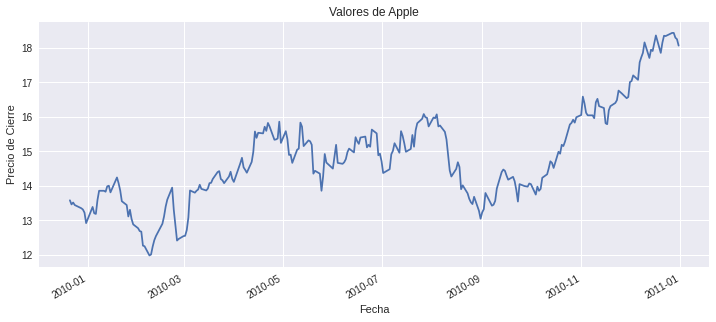

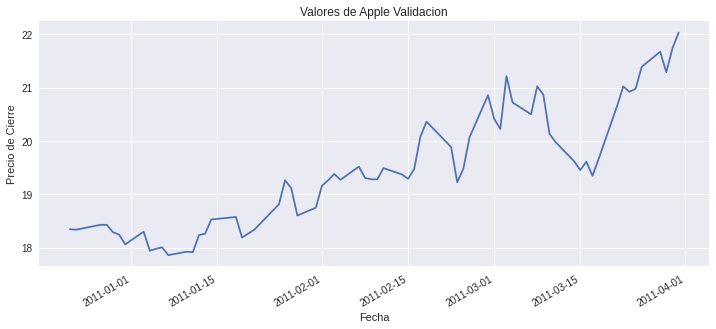

In [8]:
# Se visualiza los datos de entrenamiento de la RNN
datosClose.plot(figsize=(12,5),grid = True)
plt.title('Valores de Apple')
plt.ylabel('Precio de Cierre')
plt.xlabel('Fecha')
plt.show()

# Se visualiza los datos de validación de la RNN
datosClose_val.plot(figsize=(12,5),grid = True)
plt.title('Valores de Apple Validacion')
plt.ylabel('Precio de Cierre')
plt.xlabel('Fecha')
plt.show()

### Transformación de datos para entrenamiento de RNN.
Escalamos los datos y dividimos entre datos de entrenamiento y prueba con el método HOLDOUT (70/30).

Tenemos una longitud de, en este caso, 7 días y predecimos el día siguiente. 

Dividimos los datos en secuencicas de una longitud determinada (así lo pide las RNN)

In [9]:
def cut_timestep(x,y,time,timeStep):  
    Xt = []
    yt = []
    ind_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i]) # funcion pandas, devuelve la fila i
        ind_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(ind_time)

In [11]:
timestep = 7 # Longitud de la secuencia.

X = np.array(datosClose).reshape(-1, 1) ; X_val = np.array(datosClose_val).reshape(-1, 1)
index_time = np.array(datosClose.index); index_time_val = np.array(datosClose_val.index)
y = datosClose ; y_val = datosClose_val

scaler = MinMaxScaler() # Escalamos los datos
X_aux = np.concatenate((X,X_val), axis=0)
X_aux = scaler.fit_transform(X_aux)
X_scaled = X_aux[0:len(X)] ; X_scaled_val = X_aux[len(X):len(X_aux)]

# Creacion de los timestep (perdemos los timeStep primeros)
X, y, index_time = cut_timestep(X_scaled,y,index_time,timestep)
X_val, y_val, index_time_val = cut_timestep(X_scaled_val,y_val,index_time_val,timestep)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P = y.shape[0]
indices = np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train = indices[0:int(P*2/3)]
sequences_test = indices[int(P*2/3):]
X_train, X_test, y_train, y_test = X[sequences_train],X[sequences_test],y[sequences_train],y[sequences_test]

### Construcción y entrenamiendo de RNN.

Construimos una RNN y usamos como método de entrenamiento una función escrita en TENSORFLOW.

Esta función mide la diferenccia entre el valor real y el valor predicho, si es mayor de 0.05 lo puntúa como mala.

In [12]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [22]:
modelRNN = Sequential()
modelRNN.add(SimpleRNN(input_shape=(7,1),units=4,activation='relu',return_sequences=True))
modelRNN.add(SimpleRNN(2,activation="relu"))
modelRNN.add(Dense(1)) 
modelRNN.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN.summary()
historyRNN = modelRNN.fit(X_train,
                  y_train,
                  epochs=500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 7, 4)              24        
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 2)                 14        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 0s 51ms/step - loss: 219.9139 - porcentaje_margen: 0.0000e+00 - val_loss: 225.0456 - val_porcentaje_margen: 0.0000e+00
Epoch 2/500
6/6 [==============================] - 0s 6ms/step - loss: 219.4897 - porcentaje_margen: 0.0000e+00 - val_loss: 224.6080 - val_porcentaje_margen: 0.0000e+00
Epoch 3/500
6/6 [==============================] 

In [14]:
modelGRU = Sequential()
modelGRU.add(GRU(input_shape=(7,1),units=4,activation='relu',return_sequences=True))
modelGRU.add(GRU(2,activation="relu"))
modelGRU.add(Dense(1)) 
modelGRU.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU.summary()
historyGRU = modelGRU.fit(X_train,
                  y_train,
                  epochs=500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 4)              84        
_________________________________________________________________
gru_1 (GRU)                  (None, 2)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 0s 63ms/step - loss: 221.1772 - porcentaje_margen: 0.0000e+00 - val_loss: 226.5628 - val_porcentaje_margen: 0.0000e+00
Epoch 2/500
6/6 [==============================] - 0s 8ms/step - loss: 220.9995 - porcentaje_margen: 0.0000e+00 - val_loss: 226.3830 - val_porcentaje_margen: 0.0000e+00
Epoch 3/500
6/6 [==============================

In [15]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(input_shape=(7,1),units=4,activation='relu',return_sequences=True))
modelLSTM.add(LSTM(2,activation="relu"))
modelLSTM.add(Dense(1)) 
modelLSTM.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM.summary()
historyLSTM = modelLSTM.fit(X_train,
                  y_train,
                  epochs=500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 4)              96        
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 155
Trainable params: 155
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
6/6 [==============================] - 0s 63ms/step - loss: 221.1898 - porcentaje_margen: 0.0000e+00 - val_loss: 226.5342 - val_porcentaje_margen: 0.0000e+00
Epoch 2/500
6/6 [==============================] - 0s 7ms/step - loss: 220.9461 - porcentaje_margen: 0.0000e+00 - val_loss: 226.2851 - val_porcentaje_margen: 0.0000e+00
Epoch 3/500
6/6 [==============================

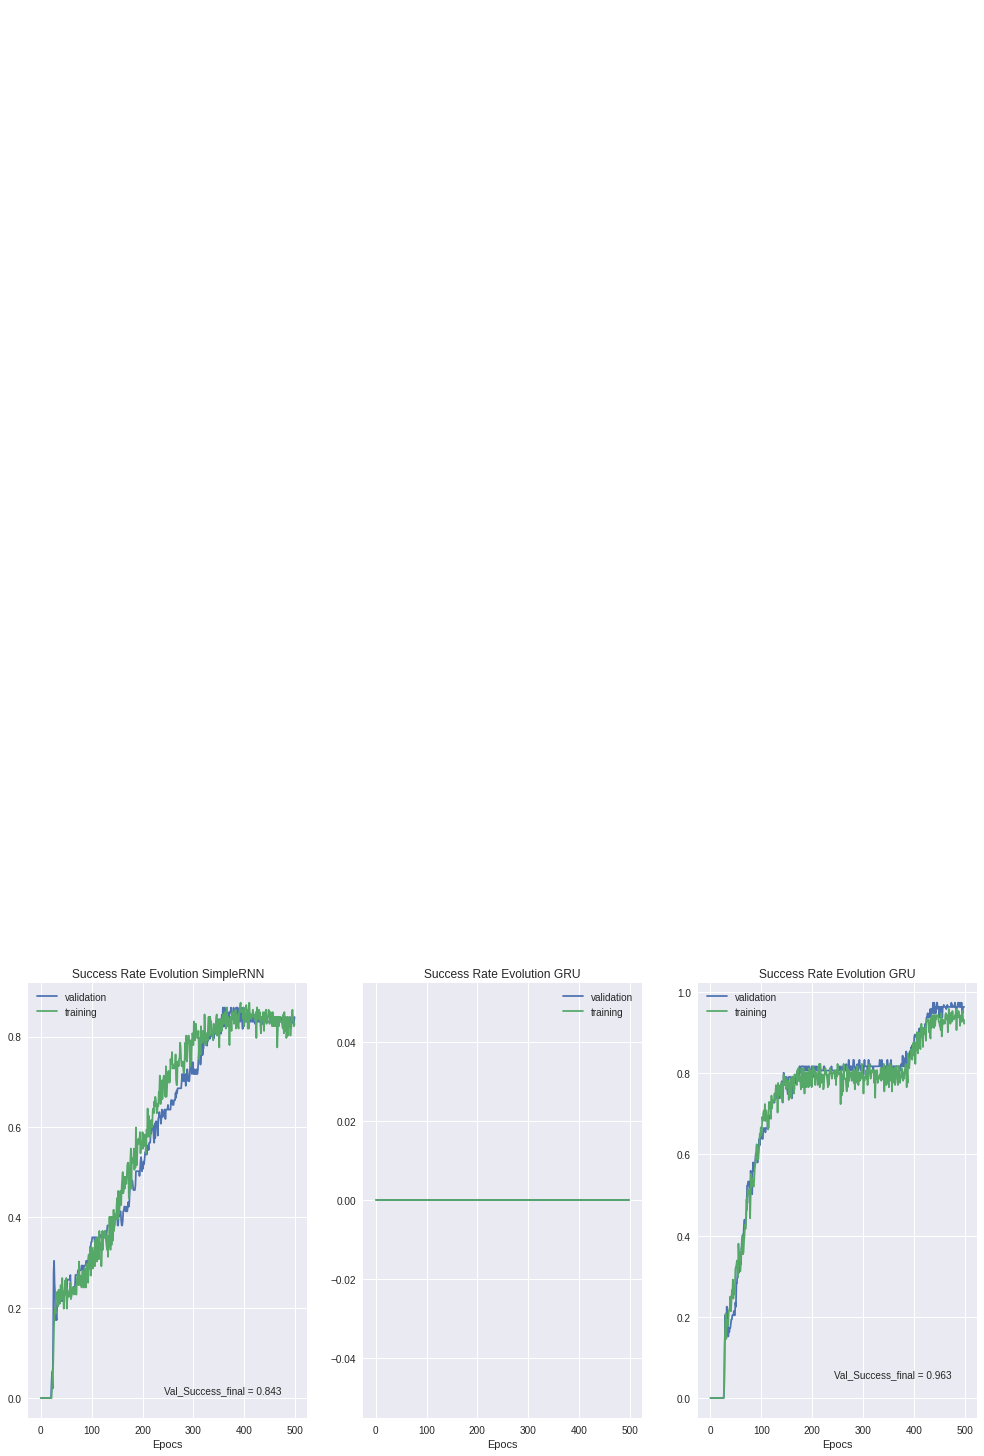

In [16]:
# Evolución de tasas de acierto por épocas.
fig, axes = plt.subplots(1, 3,figsize=(17, 8))


# Plot de la RNN
axes[0].plot(historyRNN.epoch,historyRNN.history['val_porcentaje_margen'],label='validation')
axes[0].plot(historyRNN.epoch,historyRNN.history['porcentaje_margen'],label="training")
axes[0].legend()
axes[0].set_title('Success Rate Evolution SimpleRNN')
axes[0].set_xlabel('Epocs')
axes[0].annotate('Val_Success_final = %.3f'% historyRNN.history['val_porcentaje_margen'][-1], (400, 0.01), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la GRU
axes[1].plot(historyGRU.epoch,historyGRU.history['val_porcentaje_margen'],label='validation')
axes[1].plot(historyGRU.epoch,historyGRU.history['porcentaje_margen'],label="training")
axes[1].legend()
axes[1].set_title('Success Rate Evolution GRU')
axes[1].set_xlabel('Epocs')
axes[1].annotate('Val_Success_final = %.3f'% historyGRU.history['val_porcentaje_margen'][-1], (400, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM
axes[2].plot(historyLSTM.epoch,historyLSTM.history['val_porcentaje_margen'],label='validation')
axes[2].plot(historyLSTM.epoch,historyLSTM.history['porcentaje_margen'],label="training")
axes[2].legend()
axes[2].set_title('Success Rate Evolution GRU')
axes[2].set_xlabel('Epocs')
axes[2].annotate('Val_Success_final = %.3f'% historyLSTM.history['val_porcentaje_margen'][-1], (400, 0.05), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

### Predicción de datos de validación.

Calculamos los datos predichos para todos los modelos creados y comparamos el estadístico RMSE para ver cual es mejor.

In [17]:
# Predicción
predRNN = pd.DataFrame(modelRNN.predict(X_val))
predGRU = pd.DataFrame(modelGRU.predict(X_val))
predLSTM = pd.DataFrame(modelLSTM.predict(X_val))

# Valor real del precio de la acción
indicedetiempo = pd.concat((index_time,index_time_val), axis = 0)
y = pd.DataFrame(y) ; y_val = pd.DataFrame(y_val)
stock_real_value = pd.concat((y,y_val),axis = 0)

# Calculo RMSE
rmseRNN = sqrt(mean_squared_error(y_val,predRNN))
rmseGRU = sqrt(mean_squared_error(y_val,predGRU))
rmseLSTM = sqrt(mean_squared_error(y_val,predLSTM))


### Evaluación de diferentes modelos.

Evaluamos y comparamos todos los modelos para ver cual es mejor

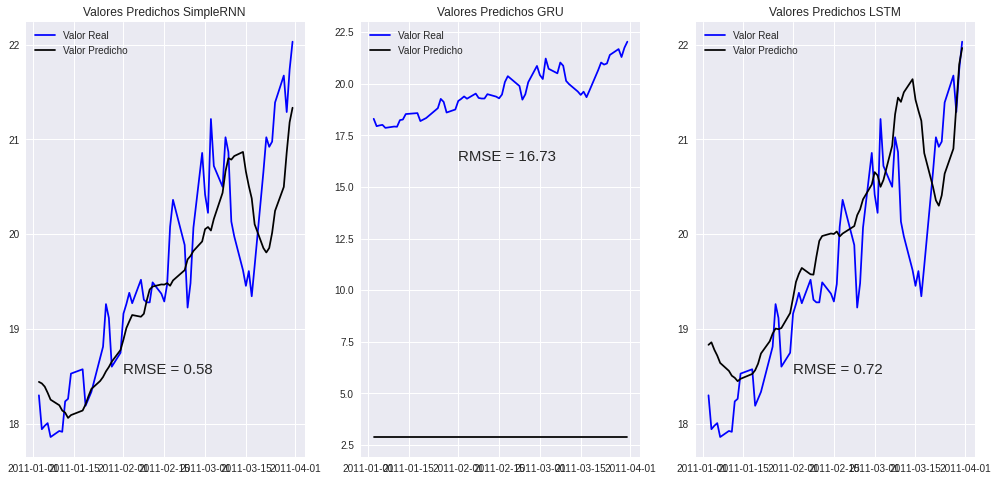

In [21]:
fig, axes = plt.subplots(1, 3,figsize=(17, 8))

# Plot de la RNN
axes[0].plot(index_time_val,y_val.values,label="Valor Real",color = "blue")
axes[0].plot(index_time_val,predRNN.values, label="Valor Predicho", color = "black")
axes[0].legend()
axes[0].set_title('Valores Predichos SimpleRNN ')
axes[0].annotate('RMSE = %.2f'% rmseRNN, (index_time_val[20], y_val.iloc[20]), xytext=(0, -60), 
            textcoords='offset points',fontsize = 15)


# Plot de la GRU
axes[1].plot(index_time_val,y_val.values,label="Valor Real",color = "blue")
axes[1].plot(index_time_val,predGRU.values, label="Valor Predicho", color = "black")
axes[1].legend()
axes[1].set_title('Valores Predichos GRU')
axes[1].annotate('RMSE = %.2f'% rmseGRU, (index_time_val[20], y_val.iloc[20]), xytext=(0, -60), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM
axes[2].plot(index_time_val,y_val.values,label="Valor Real",color = "blue")
axes[2].plot(index_time_val,predLSTM.values, label="Valor Predicho", color = "black")
axes[2].legend()
axes[2].set_title('Valores Predichos LSTM')
axes[2].annotate('RMSE = %.2f'% rmseLSTM, (index_time_val[20], y_val.iloc[20]), xytext=(0, -60), 
            textcoords='offset points',fontsize = 15)

plt.show()